
Stochastic Volatility model
================


Igor Marfin <igor.marfin@unister.de>


Abstract
----------------




--------------------------

The model discussed in this analysis was presented in
[the PyMC3 tutorial page](http://pymc-devs.github.io/pymc3/stochastic_volatility/). The aim of the work is implementaion and testing theStochastic Volatility model in terms of the ** Bayesian network**  with a help of the PyMC2. More details can be found at https://bitbucket.org/iggy_floyd/stochastic-volatility-model.



Motivation
-----

------------------------------


>Asset prices have time-varying volatility (variance of day over day returns). In some periods, returns are highly variable, while in others very stable. Stochastic volatility models model this with a latent volatility variable, modeled as a stochastic process. The following model is similar to the one described in the No-U-Turn Sampler paper, Hoffman (2011) p21.

Initialization 
--------------------------

________


In [1]:
import sys
sys.path = ['/usr/local/lib/python2.7/dist-packages'] + sys.path # to fix the problem with numpy: this replaces  1.6 version by 1.9

%matplotlib inline
%pylab inline


import os
import matplotlib 
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import logging
import pymc as pm

# a plotter and dataframe modules
import seaborn as  sns # seaborn to make a nice plots of the data
import pandas as pd
import scipy.stats as stats

# use a nice style for plots and the notebook

import json
s = json.load( open("styles/my_matplotlibrc.json") )
matplotlib.rcParams.update(s)

from IPython.core.display import HTML
from IPython.display import display, Math, Latex
import urllib2


def css_styling():
    styles = open("styles/custom_v3.css", "r").read()
    return HTML(styles)
css_styling()

#HTML( urllib2.urlopen('http://bit.ly/1Bf5Hft').read() )

ion()


# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:855: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Stock Returns
------------------------

-------------------------


Take note stock brokers: you're doing it wrong. When choosing which stocks to pick, an analyst will often look at the *daily return* of the stock. Suppose $S_t$ is the price of the stock on day $t$, then the daily return on day $t$ is :

$$r_t = \frac{ S_t - S_{t-1} }{ S_{t-1} } $$

The *expected daily return* of a stock is denoted $\mu = E[ r_t ] $. Obviously, stocks with high expected returns are desirable. Unfortunately, stock returns are so filled with noise that it is very hard to estimate this parameter. Furthermore, the parameter might change over time (consider the rises and falls of AAPL stock), hence it is unwise to use a large historical dataset. 

Historically, the expected return has been estimated by using the sample mean. This is a bad idea. As mentioned, the sample mean of a small sized dataset has enormous potential to be very wrong (again, see Chapter 4 for full details). Thus Bayesian inference is the correct procedure here, since we are able to see our uncertainty along with probable values.

For this exercise, we will be examining the daily returns of the GOOG (google). Before we pull in the data, suppose we ask our a stock fund manager (an expert in finance), 

> What do you think the return profile looks like for each of these companies?

Our stock broker, without needing to know the language of Normal distributions, or priors, or variances, etc. creates one distributions using the trial roulette. Suppose it looks enough like Normals, so we fit Normals to it. It may look like:

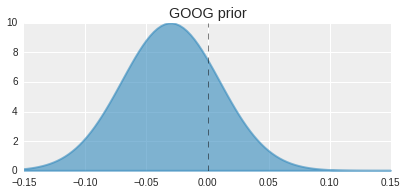

In [3]:
figsize(11., 5)
colors = ["#348ABD"]

normal = stats.norm
x = np.linspace(-0.15, 0.15, 100)

expert_prior_params = {
                       "GOOG": (-0.03, 0.04),
                       }

for i, (name, params) in enumerate(expert_prior_params.iteritems()):
    pl.subplot(2, 2, i)
    y = normal.pdf(x, params[0], scale=params[1])
    pl.fill_between(x, 0, y, color=colors[i], linewidth=2,
                     edgecolor=colors[i], alpha=0.6)
    pl.title(name + " prior")
    pl.vlines(0, 0, y.max(), "k", "--", linewidth=0.5)
    pl.xlim(-0.15, 0.15)
pl.tight_layout()
pl.savefig('plots/google_return_prior_expert.png')

Note that this is subjective prior: the expert has a personal opinion on the stock returns, and is expressing them in a distribution. He's not wishful thinking -- he's introducing domain knowledge.

Next we pull historical data for this stock:

In [4]:

import datetime
import ystockquote as ysq

stocks = [ "GOOG"]

enddate = datetime.datetime.now().strftime("%Y-%m-%d")  # today's date.
startdate = "2014-09-01"

stock_closes = {}
stock_returns = {}
CLOSE = 6

import operator




for stock in stocks:

    data=np.array(sorted(ysq.get_historical_prices(stock, startdate, enddate).items(),key=operator.itemgetter(0)))    
    x = data[:,1,None]
    stock_closes[stock] = np.apply_along_axis(lambda x:float(x[0]['Close']),1,x)                                  
    n_observations = len(stock_closes[stock])

# create returns:

for stock in stocks:
    _previous_day = np.roll(stock_closes[stock], -1)
    stock_returns[stock] = ((stock_closes[stock] - _previous_day) / _previous_day)[:n_observations]
    



dates = map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), data[:,0][1:n_observations + 1])


Let's plot the stock returns

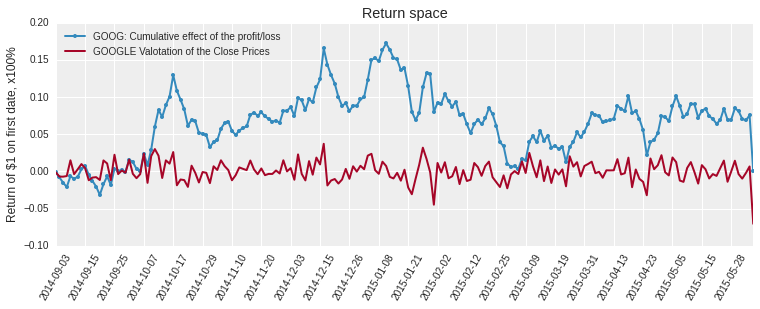

In [5]:
figsize(12.5, 4)

for _stock, _returns in stock_returns.iteritems():
    p = plt.plot((1 + _returns)[::].cumprod() - 1, '-o', label="%s: Cumulative effect of the profit/loss" % _stock,
                 markersize=4, markeredgecolor="none") # calculate the cumulative effect


plt.xticks(np.arange(n_observations)[::8],
           map(lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"), dates[::8]),
           rotation=60);

plt.plot(stock_returns['GOOG'],label='GOOGLE Valotation of the Close Prices')

plt.legend(loc="upper left")
plt.title("Return space")
plt.ylabel("Return of $1 on first date, x100%");
pl.savefig('plots/google_returns.png')


Realization of the **Stochastic Volatility model**
-----------------

----------------

The following model is our choice:

$$ \sigma \sim Exponential(50), \\
\nu \sim Exponential(.1), \\
s_i \sim Normal(s_{i−1},\sigma^{−2}), \\
\log(\frac{y_i}{y_{i−1}}) \sim t(\nu,0,exp(−2s_i))
 $$

It is easier to sample the scale of the log volatility process innovations, i.e. \sigma on a log scale.

In [6]:

class SVM(object):
    """Stochastic Volatility model using pymc2."""

    def __init__(self, train_data,  sigma_mu=50.,nu_mu=.1 ):
        """Build the Probabilistic Matrix Factorization model using pymc2.
        """
        
        
        # occupy a lot of memory        
        self.data = train_data
        N = self.data.shape[0]
        
        # Specify the model.
        logging.info('building the SVM model')
        
        # define our bayesian model here
      
        # sigma and logsigma
        self.sigma =  pm.Exponential('sigma', beta=sigma_mu)
        self.logsigma = pm.Lambda('logsigma', lambda  x = self.sigma: np.log(x))
        
        # nu 
        self.nu = pm.Exponential('nu', beta=nu_mu,size=N)
        
        # here we define s_i \sim Normal(s_{i−1},\sigma^{−2})
        self.si=np.empty(N,dtype=object)
        self.si[0] =  pm.Normal("s%i"%0, 0., 1.0 / self.sigma ** 2)        
        for i in range(1,N):
            self.si[i] = pm.Normal("s%i"%i,self.si[i-1], 1.0 / self.sigma ** 2)
        
        self.volatility_process = np.empty(N,dtype=object)
        for i in range(0,N):
            self.volatility_process[i] = pm.Lambda('vp%i'%i,lambda  x = self.si[i]: np.exp(-2.*x))
            
        #Deterministic('volatility_process', exp(-2*s))
        
        # here we define observed
        self.r = pm.NoncentralT('obs', np.zeros(N), self.volatility_process,self.nu, value=self.data, observed=True,size=N)
        #T('r', nu, lam=volatility_process, observed=returns)
        #r = T('r', nu, lam=volatility_process, observed=returns)
        
        # define our model        
        self.model = pm.Model([self.sigma, self.logsigma] +   self.si.tolist() + self.volatility_process.tolist() + [self.r ] )
        #self.model = pm.Model(self.si.tolist() + )
        
       
        logging.info('done building the SVM model') 
        

    def __str__(self):
        return self.name

In [7]:
# Test of Bayesian SVM

svm = SVM(stock_returns['GOOG'][-100:])
?svm




INFO:root:building the SVM model
INFO:root:done building the SVM model


Let's add MCMC support to our model.

In [8]:
# Draw MCMC samples.
def _trace_dir(self):
    basename = 'svm-mcmc' 
    return os.path.join('data', basename)



# Sampler 
def _draw_samples(self, nsamples=1000):
    # First make sure the trace_dir does not already exist.
    #if os.path.isdir(self.trace_dir):
    #    raise OSError(
    #        'trace directory %s already exists. Please move or delete.' % self.trace_dir)

    # pymc2
    logging.info('drawing %d samples ' % (nsamples))
    self.mcmc =pm.MCMC(self.model,db='txt',dbname=self.trace_dir)    
    logging.info('backing up trace to directory: %s' % self.trace_dir)
    self.mcmc.sample(nsamples)
    self.traces={}
    
    for var in list(self.mcmc.stochastics):
        self.traces.update(
                            { str(var):self.mcmc.trace(str(var))[:] }                        
                        )
    
    self.mcmc.db.close()
   
    
def _load_trace(self):
    self.mcmc = pm.MCMC(self.model,db=pm.database.txt.load(self.trace_dir))     
    
    self.traces={}
    for var in list(self.mcmc.stochastics):
        self.traces.update(
                            { str(var):self.mcmc.trace(str(var))[:] }                        
                        )    
 

In [9]:
# Update our class with the sampling infrastructure.
SVM.trace_dir = property(_trace_dir)
SVM.draw_samples = _draw_samples
SVM.load_trace = _load_trace

Let's try to MCMC

In [10]:
if not os.path.isdir(svm.trace_dir):
    svm.draw_samples(50000)
else:
    svm.load_trace()
   

In [16]:
print svm.traces

{'s9': array([ 0.00835274,  0.01119426,  0.01880646, ..., -0.00697961,
       -0.02101692, -0.02101692]), 's8': array([ 0.05079409,  0.00147771,  0.00147771, ..., -0.00451087,
       -0.01208076, -0.01208076]), 's3': array([-0.05121066, -0.07201002, -0.13360883, ...,  0.00085611,
       -0.00329013, -0.00329013]), 's2': array([-0.01874881, -0.010271  , -0.03232809, ...,  0.00156825,
       -0.0004372 , -0.00486987]), 's1': array([-0.00421045, -0.00085151, -0.00345045, ..., -0.02290941,
       -0.02311715, -0.02311715]), 's0': array([ 0.03124273,  0.02905708,  0.03923831, ...,  0.00507513,
        0.00507513, -0.00109334]), 's7': array([-0.03538399, -0.00717455, -0.00717455, ...,  0.02262506,
        0.02262506,  0.01588623]), 's6': array([-0.04851927, -0.04851927, -0.04851927, ...,  0.01648653,
        0.01648653,  0.01648653]), 's5': array([-0.10418081, -0.09653195, -0.0657978 , ...,  0.00303172,
        0.00303172,  0.00303172]), 's4': array([-0.11135461, -0.11135461, -0.11135461, ..

We can make control plots to look at auto-correlations.

Plotting sigma
Plotting logsigma


[None, None]

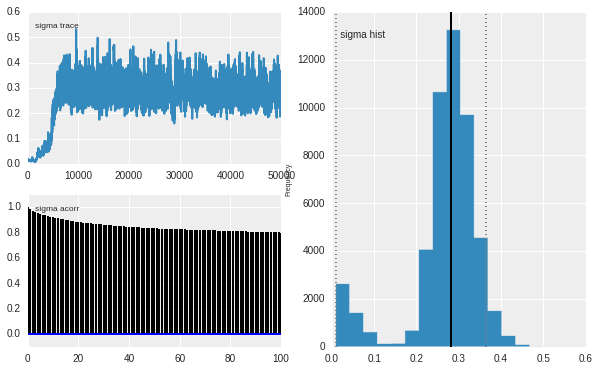

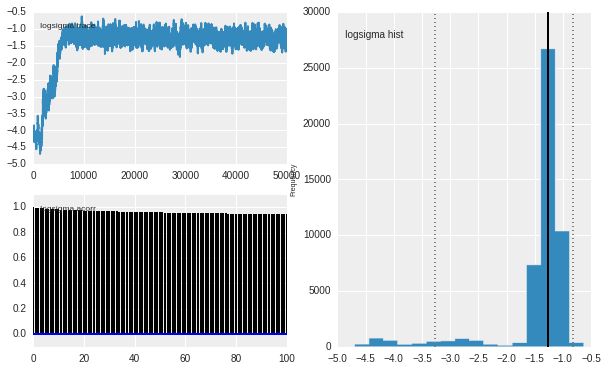

In [11]:
from pymc.Matplot import plot as mcplot
[mcplot(svm.sigma,path='plots/'),mcplot(svm.logsigma,path='plots/')]



Here we do the GoF of some parameters and other diagnostic plots

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


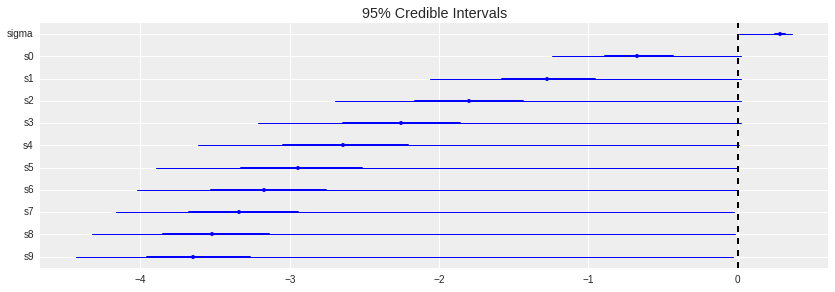

In [12]:
from pymc import Matplot, gelman_rubin
#svm.draw_samples(50000)


# plot CI on some parameters and Gelman-Rubin statistic
Matplot.summary_plot([svm.sigma]+svm.si[:10].tolist(),path='plots/',rhat=True)


In [14]:
#gelman_rubin(svm.mcmc.trace)
#gelman_rubin(svm.mcmc.trace('sigma')[:])

In [124]:
svm.si[10].trace()

array([-0.07652315, -0.07652315, -0.05681686, ..., -3.86964306,
       -3.86964306, -3.96117435])

In [126]:
from pymc import discrepancy

# check discrepancy for svm.si[10]
#expected = svm.si[10].trace()
#d = discrepancy(svm.data,svm.r, expected)
#d[0][:10], d[1][:10]


Now, we plot the volatility...

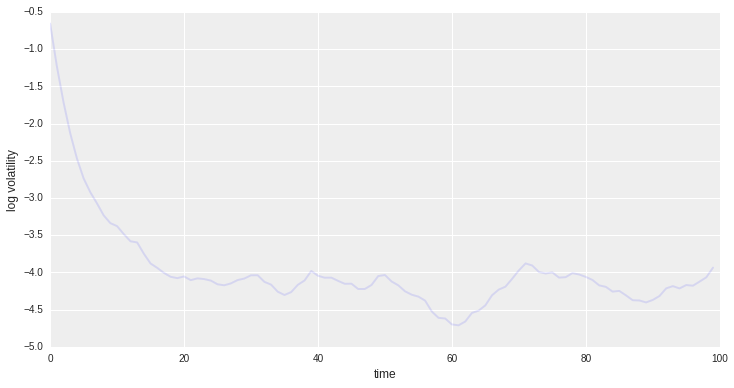

In [15]:
# plot the valotility
figsize(12,6)
#title(str(s))
plt.plot(
    #np.array([svm.traces['s%i'%key][::1000] for key in range(len(svm.si))]),
    np.array([svm.traces['s%i'%key].mean() for key in range(len(svm.si))]),
    'b', alpha=.1);
xlabel('time')
ylabel('log volatility')
pl.savefig('plots/google_volatility.png')




Finally, we can superimpose the volatility predictions with dayly return of the GOOGle stock.

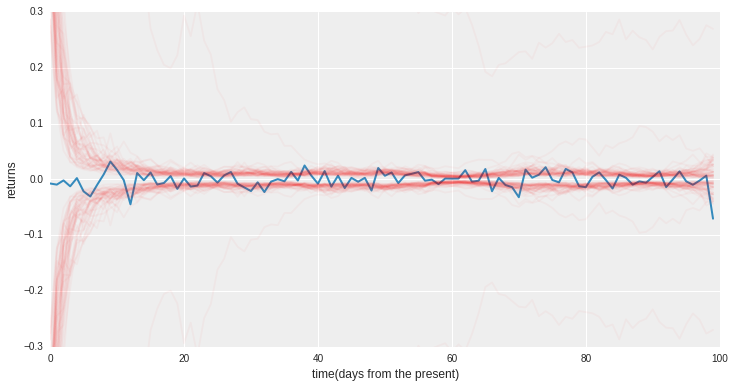

In [16]:
plt.plot(stock_returns['GOOG'][-100:])
plt.plot(
    np.exp(
     np.array([svm.traces['s%i'%key][::1000]  for key in range(len(svm.si))])
    )
, 'r', alpha=.03);


plt.plot(
    -np.exp(
     np.array([svm.traces['s%i'%key][::1000]  for key in range(len(svm.si))])
    )
    , 'r', alpha=.03);


ylim(-0.3,0.3)
xlabel('time(days from the present)')
ylabel('returns')
pl.savefig('plots/google_volatility_returns.png')

References
-------------------

-------------------




Hoffman & Gelman. (2011). [The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo.](http://arxiv.org/abs/1111.4246)